# Explicando Retrieval Augmented Generation

Neste exemplo, vamos carregar um PDF para utilizá-lo como base de conhecimento para tratamentos de dúvidas.

Utilizaremos os modelos da OpenAI para gerar embeddings e respostas.

Os dados vetorizados serão armazenados no Astra/Cassandra para busca baseada na similaridade de vetores (Vector Search).

## Configurando ambiente

Inicialmente, vamos instalar e configurar o ambiente para execução dos modelos

In [1]:
pip install langchain llama-index openai cassio --upgrade 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.4/796.4 kB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nest-asyncio
    Found existing installation: nest-asyncio 1.5.6
    Uninstalling nest-asyncio-1.5.6:
      Successfully uninstalled nest-asyncio-1.5.6
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.0.41
    Uninstalling langsmith-0.0.41:
      Successfully uninstalled langsmith-0.0.41
  Attempting uninstall: langchain
    Found existing installation: langchain 0.0.305
    Uninstalling langchain-0.0.305:
      Successfully uninstalled langchain-0.0.305
  Attempting uninstall: llama-index
    Found existing installation: llama-index 0.8.37
    Uninstalling llama-index-0.8.37:
      Successfully u

In [3]:
# Carregando variáveis de ambiente
from dotenv import load_dotenv, find_dotenv
import os
load_dotenv(find_dotenv(), override=True)

True

## Retrieval Augmented Generation - Process Flow
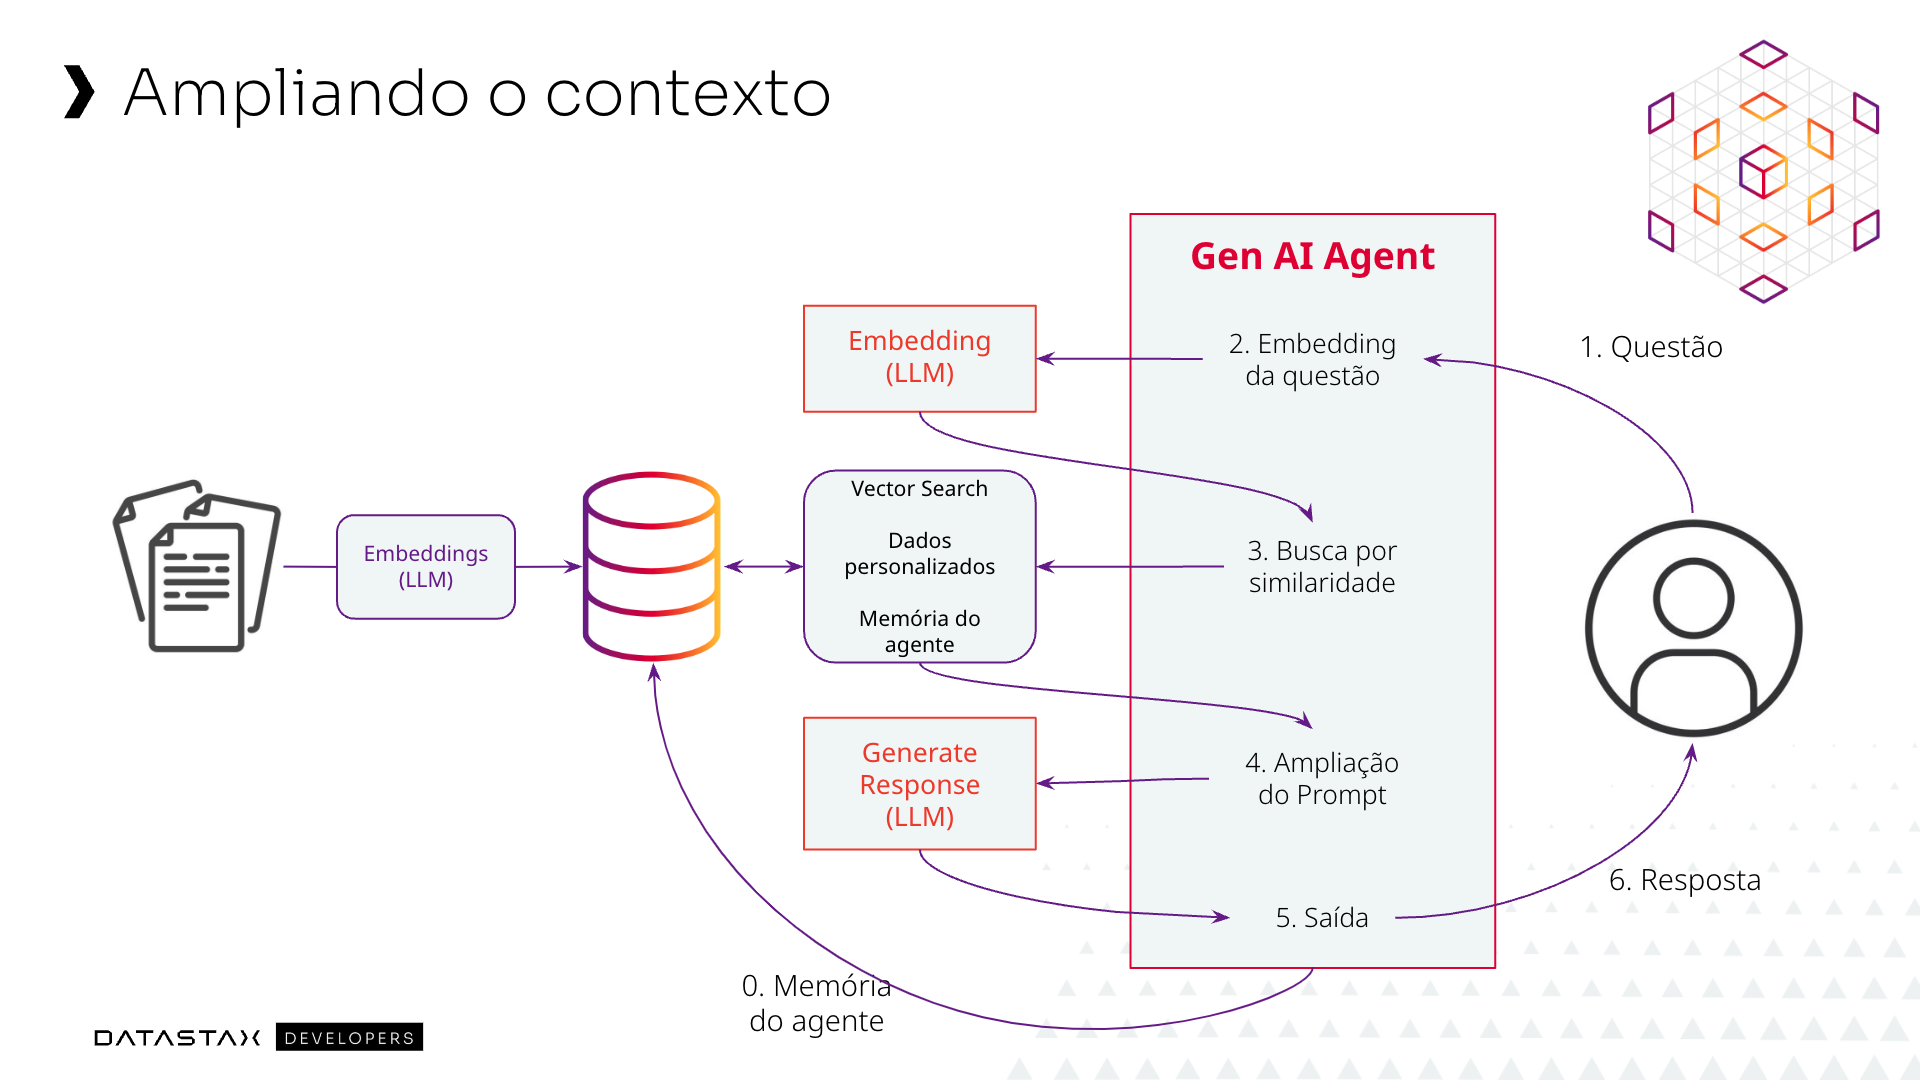

## Conectando ao Astra/Cassandra

Para utilizar o Cassandra como Vector DB, crie um banco de dados com suporte a vvector search em astra.datastax.com, gere um token de conexão e identifique o seu DB ID. Com isso, execute o comando abaixo para criar a conexão

In [4]:
import cassio

cassio.init(token=os.environ["ASTRA_DB_APPLICATION_TOKEN"], database_id=os.environ["ASTRA_DB_ID"])

Pronto!

A conexão com o Astra é muito simples e você já pode armazenar seus documentos.

## Setup LangChain, Cassandra e OpenAI

In [5]:
# Importando o índice, separadores de texto, e auxiliares para processamendo dos documentos
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.indexes.vectorstore import VectorstoreIndexCreator
from langchain.text_splitter import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
)
from langchain.docstore.document import Document
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader

### Embeddings

Vamos converter nossa base de documentos em embeddings. 

Se você não sabe o que são embeddings, assista aqui: https://www.youtube.com/watch?v=fvRyziDmvoA

Utilizaremos o LangChain para simplificar a leitura dos PDFs, geração de chunks e posterior utilização dos dados.

In [6]:
# Neste exemplo, vou utilizar os embeddings da OpenAI.
# Aqui, importamos o LLM e os Embeddings
from langchain.llms import OpenAI
from langchain.embeddings import OpenAIEmbeddings
llm = OpenAI(temperature=0.5)
embedding_generator = OpenAIEmbeddings()

### Definindo o Index/Tabela do Cassandra que vai armazenar os dados

In [7]:
# O LangChain possui suporte ao Cassandra, então vamos utilizá-lo
# (vamos usar o Astra, que é o Cassandra como serviço)
# Criando o índice no Astra

from langchain.vectorstores.cassandra import Cassandra
table_name = 'vs_contract'
keyspace = 'demo'

In [144]:
# Se necessário, execute este comando para limpar a tabela com os dados
#CassVectorStore.clear()

## Criando o index e carregando

O método IndexCreator executa a criação da tabela e vincula qual modelo de embeddings será utilizado no índice

In [8]:
index_creator = VectorstoreIndexCreator(
    vectorstore_cls=Cassandra,
    embedding=embedding_generator,
    text_splitter=RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=30,
    ),
    vectorstore_kwargs={
        'session': cassio.config.resolve_session(),
        'keyspace': 'demo',
        'table_name': table_name,
    },
)

In [16]:
# Carregando os dados de um contrato específico
#loader = PyPDFDirectoryLoader('./funds')
loader = PyPDFLoader("/Users/samuel.matioli/work/gen-ai/demos/pdf/188411.pdf")
index = index_creator.from_loaders([loader])

### Se o seu índice já estiver carregado...

... você pode referenciá-lo desta maneira.

In [22]:
CassVectorStore = Cassandra(
    session= cassio.config.resolve_session(),
    keyspace= 'demo',
    table_name= table_name,
    embedding=embedding_generator
)

index = VectorStoreIndexWrapper(
    vectorstore=CassVectorStore
)

### Conferindo os dados gravados

Faremos uma query no Vector Store para conferir como os dados foram gravados

In [ ]:
cqlSelect = f"""SELECT * FROM {keyspace}.{table_name} 
WHERE metadata_s['source'] = '/Users/samuel.matioli/work/gen-ai/demos/pdf/188411.pdf'
LIMIT 2;"""

rows = cassio.config.resolve_session().execute(cqlSelect)
for row_i, row in enumerate(rows):
    print(f'\n{"-"*50}')
    print(f'\nRow {row_i}:')
    print(f'    document_id:      {row.row_id}')
    print(f'    embedding_vector: {str(row.vector)[:64]} ...')
    print(f'    metadata_blob:    {row.metadata_s}')
    print(f'    document:         {row.body_blob[:60]} ...')

print('\n...')

# Utilizando o documento para responder uma pergunta

O LangChain possui métodos que buscam documentos similares no index e compõem um prompt para gerar a resposta a uma pergunta.

Este método são o ``ìndex.query`` e ``index.query_with_sources``.

A diferença entre estes métodos é o tipo de RetrievalChain que são utilizados por cada um.


Estes métodos funcionam bem, mas na vida real precisaremos de mais flexibilidade e detalhamento no comportamento do LLM, modificando o prompt para fornecer mais instruções, ou filtrando documentos que queremos que sejam considerados.

Por isso, o melhor é usarmos as mesmas Chains utilizadas acima, mas agora podendo especificar mais detalhes. 

Vamos ver como fazer isso.

## Q/A passo a passo

### Buscando documentos pela similaridade

A busca pelos documentos que vão preencher o contexto pode utilizar estratégias distintas.

Iniciaremos com a busca por similaridade de vetores.

In [ ]:
matchesSim = CassVectorStore.search(QUERY, search_type='similarity', k=4)
print(QUERY)
for i, doc in enumerate(matchesSim):
    print(f'[{i:2}]: "{doc.page_content[:60]}..."')

## Utilizando a Chain com prompt personalizado
Vamos usar estes documentos para preencher o prompt. Note que nos próximos passos iremos importar as Chains e também definir o prompt que queremos utilizar.

In [28]:
from langchain.chains.retrieval_qa.base import RetrievalQA
from langchain import PromptTemplate

In [29]:
prompt_template = """
Given the following extracted parts of a long document and a question, create a final answer with references ("SOURCES"). 
If you don't know the answer, just say that you don't know. Don't try to make up an answer.
ALWAYS return a "SOURCES" part in your answer. Answer in Portuguese.


QUESTION: {question}
=========
{summaries}
=========
FINAL ANSWER:"""
PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["summaries", "question"]
)

In [ ]:
retrieverSim = CassVectorStore.as_retriever(
    search_type='similarity',
    search_kwargs={
        'k': 5,
    },
)
# Create a "RetrievalQA" chain
chainSim = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retrieverSim,
    chain_type_kwargs={
        'prompt': PROMPT,
        'document_variable_name': 'summaries'
    }
)
# Run it and print results
responseSim = chainSim.run(QUERY)
print(responseSim)

In [ ]:
# manual creation of the "retriever" with the 'similarity' search type
retrieverMMR = CassVectorStore.as_retriever(
    search_type='mmr',
    search_kwargs={
        'k': 5,
        'fetch_k': 10,
        'filter': {"source": "./funds/RealInvFIM0623.pdf"}
    },
    return_source_documents=True
)

# Create a "RetrievalQA" chain
chainMMR = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retrieverMMR,
    chain_type_kwargs={
        'prompt': PROMPT,
        'document_variable_name': 'summaries'
    }
)
# Run it and print results
responseSim = chainMMR.run(QUERY)
print(responseSim)

## Adicionando memória

In [188]:
from langchain.memory import CassandraChatMessageHistory
from langchain.memory import ConversationSummaryBufferMemory
memory_table_name = 'astra_agent_memory'

In [ ]:

def get_answer(conversation_id, q):
    prompt_template = """
    Given the following extracted parts of a long document and a question, create a final answer in a very short format. 
    If you don't know the answer, just say that you don't know. Don't try to make up an answer.
    Answer in Portuguese.


    QUESTION: {question}
    =========
    {summaries}
    =========
    FINAL ANSWER:"""

    PROMPT = PromptTemplate(
        template=prompt_template, input_variables=["summaries", "question"]
    )

    message_history = CassandraChatMessageHistory(
        session_id=conversation_id,
        session= cassio.config.resolve_session(),
        keyspace= cassio.config.resolve_keyspace(),
        ttl_seconds=3600,
        table_name=memory_table_name
    )

    memory = ConversationSummaryBufferMemory(
        llm=llm,
        chat_memory=message_history,
        max_token_limit=50,
        buffer=""
    )

    retrieverSim = CassVectorStore.as_retriever(
        search_type='similarity_score_threshold',
        search_kwargs={
            'k': 5,
            'filter': {"source": "./funds/RealInvFIM0623.pdf"},
            "score_threshold": .8
        },
    )
    
    # Create a "RetrievalQA" chain
    chainSim = RetrievalQA.from_chain_type(
        llm=llm,
        retriever=retrieverSim,
        memory=memory,
        chain_type_kwargs={
            'prompt': PROMPT,
            'document_variable_name': 'summaries'
        }
    )
    
    # Run it and print results
    answer = chainSim.run(q)

    return answer

langchain.debug = True
langchain.verbose = False
res = get_answer('my_conv2',"Simule a aplicação de 1000")
print("="*20)
print(res)

In [ ]:
from langchain.chains import ConversationalRetrievalChain

def get_answer(conversation_id, q):
    prompt_template = """
    Given the following extracted parts of a long document and a question, create a final answer in a very short format. 
    If you don't know the answer, just say that you don't know. Don't try to make up an answer.
    Answer in Portuguese.


    QUESTION: {question}
    =========
    Chat History:
    ========
    {chat_history}
    ========
    {summaries}
    =========
    FINAL ANSWER:"""

    PROMPT = PromptTemplate(
        template=prompt_template, input_variables=["summaries", "question","chat_history"]
    )

    message_history = CassandraChatMessageHistory(
        session_id=conversation_id,
        session= cassio.config.resolve_session(),
        keyspace= cassio.config.resolve_keyspace(),
        ttl_seconds=3600,
        table_name=memory_table_name
    )

    memory = ConversationSummaryBufferMemory(
        llm=llm,
        chat_memory=message_history,
        max_token_limit=50,
        buffer="",
        return_messages=True,
        memory_key="chat_history"
    )

    retrieverSim = CassVectorStore.as_retriever(
        search_type='similarity_score_threshold',
        search_kwargs={
            'k': 5,
            'filter': {"source": "./funds/RealInvFIM0623.pdf"},
            "score_threshold": .8
        },
    )

    qa = ConversationalRetrievalChain.from_llm(
        llm=llm,
        retriever = retrieverSim,
        memory=memory
    )

    answer = qa({"question": q})
    
    return answer

langchain.debug = False
langchain.verbose = True
res = get_answer('my_conv3',"Qual o rendimento?")
print("="*20)
print(res)